## Calculate Permutation Importance

## Prep for analysis

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import random 
from datetime import datetime
import pandas as pd
import os 

import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/utils/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/utils/')
from exp_hp import get_hp
from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results, adjust_spines
from dataprep_utils import get_testing
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/interpret/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/interpret/')
from Gordon_interp import confvacc


# import importlib
# importlib.reload(sys.modules["Gordon_interp"])
# from Gordon_interp import getoutputvecs, confvacc, iconfcorr
# importlib.reload(sys.modules["trainGordon_utils"])
# from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

### Load network:

In [4]:
MODEL_DIR = '/glade/scratch/wchapman/ENSOmjo_ML_models/saved_models/'
EXP_NAME = 'default'
hps = get_hp(EXP_NAME)
# variables:
DROPOUT_RATE = hps['DROPOUT_RATE']

MODELNAME1 = 'ENSO'
RIDGE1 = hps['RIDGE1']
HIDDENS1 = hps['HIDDENS1']

MODELNAME2 = 'MJO'
RIDGE2 = hps['RIDGE2']
HIDDENS2 = hps['HIDDENS2']

BATCH_SIZE = hps['BATCH_SIZE']
N_EPOCHS = 10000
PATIENCE = hps['PATIENCE'] # number of epochs of no "improvement" before training is stopped
LR = hps['LR'] # learning rate


LEADS = np.arange(7,31)
AVGS = np.arange(7,32)
SEEDS = np.arange(1,6)

SAVE = True

### Analyze Data

LEAD: 7
AVG: 7


2023-10-11 10:03:32.399770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


362/362 [==============================] - 1s 2ms/step


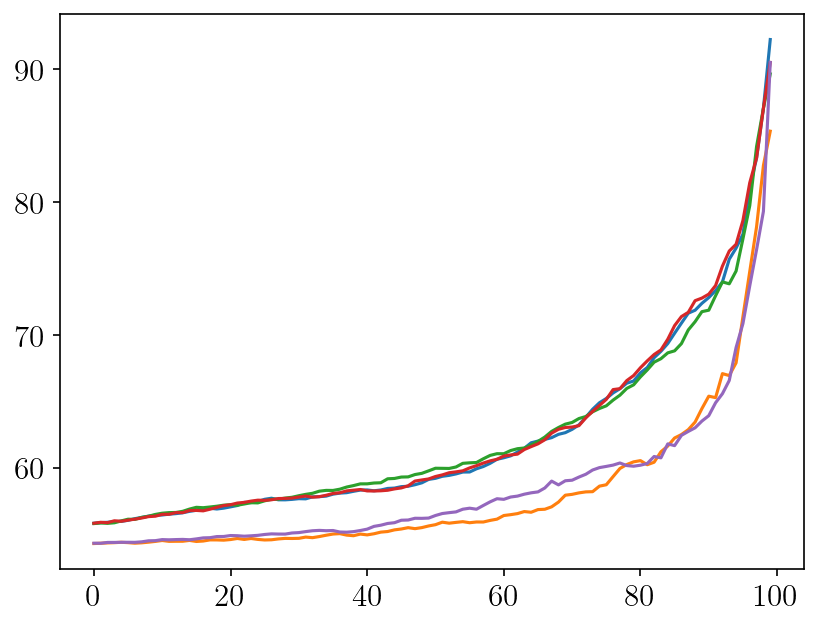

saving
LEAD: 7
AVG: 8
361/361 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 9
360/360 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 10
359/359 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 11
357/357 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 12
358/358 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 13
360/360 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 14
360/360 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 15
361/361 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 16
359/359 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 17
360/360 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 18
360/360 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 19
360/360 [==============================] - 1s 2ms/step
saving
LEAD: 7
AVG: 20
359/359 [==============================] - 

In [ ]:
# model raw predictions
# confidence vs accuracy
# model contribution fractions

for l in LEADS:
    for a in AVGS:
        print('LEAD: '+str(l)+'\nAVG: '+str(a))
        
        #check if files already exist:
        ddir_save = '/glade/scratch/kjmayer/DATA/ENSOvsMJO/data/'
        finame_confvsacc = 'confvsacc_permutimport-ENSO_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
        if not os.path.isfile(ddir_save+finame_confvsacc):
            # print('load testing data')
            
            ## ----- MJO PERMUTATION IMPORTANCe -----
            #X1test, X2test_noshuffle, Ytest = get_testing(N_z500runmean=a,
            #                                    LEAD=l)

            
            ## shuffle MJO network input (X2test)
            #ishuffle_X2 = np.random.choice(a=np.shape(X2test_noshuffle)[0],
            #                                size=np.shape(X2test_noshuffle)[0],
            #                                replace=False)
            #X2test = X2test_noshuffle[ishuffle_X2]
            
            # dont forget to change model_og_rawpreds & save file name (below)
            
            
            # ----- ENSO PERMUTATION IMPORTANCe -----
            X1test_noshuffle, X2test, Ytest = get_testing(N_z500runmean=a,
                                                LEAD=l)

            # shuffle ENSO network input (X1test)
            ishuffle_X1 = np.random.choice(a=np.shape(X1test_noshuffle)[0],
                                            size=np.shape(X1test_noshuffle)[0],
                                            replace=False)
            X1test = X1test_noshuffle[ishuffle_X1]
            
            
            # ------
            INPUT_SHAPE1 = np.shape(X1test)[1:][0]
            INPUT_SHAPE2 = np.shape(X2test)[1:][0]

            confvsacc = np.zeros(shape=(len(SEEDS),100))
            
            for s in SEEDS:
                # ENSO MODEL
                model1, input1 = build_model(s,
                                             DROPOUT_RATE,
                                             RIDGE1,
                                             HIDDENS1,
                                             INPUT_SHAPE1,
                                             MODELNAME1)
                # MJO MODEL
                model2, input2 = build_model(s,
                                             DROPOUT_RATE,
                                             RIDGE2,
                                             HIDDENS2,
                                             INPUT_SHAPE2,
                                             MODELNAME2)   
                # COMBINE ENSO & MJO MODEL
                model = fullmodel(model1, model2,
                                  input1, input2,
                                  s)

                MODEL_FINAME = 'LEAD_'+str(l)+'_AVG_'+str(a)+'__0000'+str(s)+'.h5'
                model.load_weights(MODEL_DIR+MODEL_FINAME)
                
                # ----- MJO no shuffle
                # model_og_rawpreds = model.predict((X1test,X2test_noshuffle))
                
                # ----- ENSO no shuffle
                model_og_rawpreds = model.predict((X1test_noshuffle,X2test))
                conf_og    = np.max(model_og_rawpreds,axis=-1)
                
                model_rawpreds = model.predict((X1test,X2test))                
                predval = np.argmax(model_rawpreds,axis=-1)
                
                # ----- confidence vs accuracy for all seeds: -------------------------------------------
                # evaluate skill of shuffled data model,
                # where model with no shuffled data was confident
                confvsacc[s-1], _, _ = confvacc(confval = conf_og, # confidence values for original model
                                                predval = predval, # predict values with shuffled X2test
                                                Ytest   = Ytest)
                
                if l == 7 and a == 7:
                    plt.plot(confvsacc[s-1])
            
            plt.show()

            if SAVE:
                print('saving')
                ddir_save = '/glade/scratch/kjmayer/DATA/ENSOvsMJO/data/'
                finame_confvsacc = 'confvsacc_permutimport-ENSO_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_confvsacc, confvsacc)